In [1]:
%config Completer.use_jedi = False
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision

from src import utils
from src import pytorch_utils as ptu
from config import cfg

import warnings
warnings.filterwarnings("ignore")

In [3]:
cfg.tqdm_bar = True
cfg.prints = 'display'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device', device)

device cpu


In [5]:
dataset = torchvision.datasets.CIFAR10(root=cfg.data_path, train=False)

In [6]:
versions = [
    'no_rotation_resnet34_adam_lr0.0003_bs32',
    'rotation_resnet34_adam_lr0.0003_bs32',
]
epoch = -1

In [7]:
# log = pd.DataFrame(columns=['model', 'model_epoch', 'img', 'label', 'pred', 'loss', 'augment', 'angle'])
log = pd.read_csv('results_log.csv')

In [8]:
log

,model,model_epoch,img,label,pred,score,loss,augment,angle
0,rotation_resnet34_adam_lr0.0003_bs32,-1,0,3,3,1,1.237721,rotate,0
1,rotation_resnet34_adam_lr0.0003_bs32,-1,1,8,8,1,0.417182,rotate,0
2,rotation_resnet34_adam_lr0.0003_bs32,-1,2,8,8,1,0.278200,rotate,0
3,rotation_resnet34_adam_lr0.0003_bs32,-1,3,0,3,0,2.661825,rotate,0
4,rotation_resnet34_adam_lr0.0003_bs32,-1,4,6,6,1,0.718933,rotate,0
...,...,...,...,...,...,...,...,...,...
199995,no_rotation_resnet34_adam_lr0.0003_bs32,-1,9995,8,0,0,1.072774,rotate,90
199996,no_rotation_resnet34_adam_lr0.0003_bs32,-1,9996,3,5,0,2.098405,rotate,90
199997,no_rotation_resnet34_adam_lr0.0003_bs32,-1,9997,5,5,1,1.231478,rotate,90
199998,no_rotation_resnet34_adam_lr0.0003_bs32,-1,9998,1,5,0,2.610535,rotate,90


In [8]:
def eval_model(log, versions, epoch, angles, device, batch_size=1):
    if not batch_size == 1:
        raise NotImplementedError
    for version in versions:
        checkpoint = ptu.load_model(device, version=version, models_dir=cfg.models_dir, epoch=epoch)
        checkpoint.model.eval()
        checkpoint.model.to(device)
        with torch.no_grad():
            for angle in angles:
                transforms = torchvision.transforms.Compose([
                    utils.RotateAngle(angles=(angle, )),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(utils.cifar10_mean, utils.cifar10_std),
                ])

                dataset = torchvision.datasets.CIFAR10(root=cfg.data_path, train=False, transform=transforms)

                loader = torch.utils.data.DataLoader(dataset,
                                                     batch_size=batch_size,
                                                     num_workers=cfg.num_workers,
                                                     shuffle=False,
                                                     drop_last=True)

                pbar = tqdm(loader)
                pbar.set_description(f'version={version}, angle={angle}')
                for i, batch in enumerate(pbar):
                    loss, results, _ = checkpoint.batch_pass(device, batch)
                    row = {
                        'model': checkpoint.version,
                        'model_epoch': epoch,
                        'img': i,
                        'label': results['trues'][0],
                        'pred': results['preds'][0],
                        'score': int(results['preds'][0] == results['trues'][0]),
                        'loss': float(loss.data),
                        'augment': 'rotate',
                        'angle': angle,
                    }
                    log = log.append(pd.Series(row), ignore_index=True)
                log.to_csv('results_log.csv', index=False)
    return log

In [13]:
angles = tuple(range(0, 100, 10))
# angles = (0, )

In [10]:
log = eval_model(log, versions, epoch, angles, device, batch_size=1)

version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=0: 100%|██████████| 10000/10000 [02:29<00:00, 66.99it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=10: 100%|██████████| 10000/10000 [02:51<00:00, 58.42it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=20: 100%|██████████| 10000/10000 [03:06<00:00, 53.72it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=30: 100%|██████████| 10000/10000 [03:21<00:00, 49.52it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=40: 100%|██████████| 10000/10000 [03:43<00:00, 44.82it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=50: 100%|██████████| 10000/10000 [03:47<00:00, 43.95it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=60: 100%|██████████| 10000/10000 [03:52<00:00, 42.94it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=70: 100%|██████████| 10000/10000 [04:08<00:00, 40.30it/s]
version=no_rotation_resnet34_adam_lr0.0003_bs32, angle=80: 100%|██████████| 10000/10000 [04:26<00

In [9]:
def f(string):
    if string == 'rotation_resnet34_adam_lr0.0003_bs32':
        return 'rotation'
    elif string == 'no_rotation_resnet34_adam_lr0.0003_bs32':
        return 'no_rotation'
    else:
        raise
log['rotations_train'] = log['model'].apply(f)
log['class'] = log['label'].apply(lambda x: dataset.classes[x])

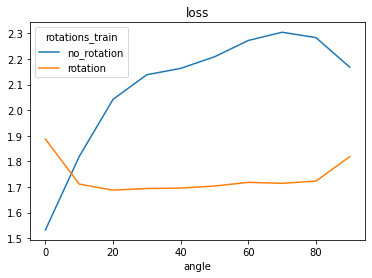

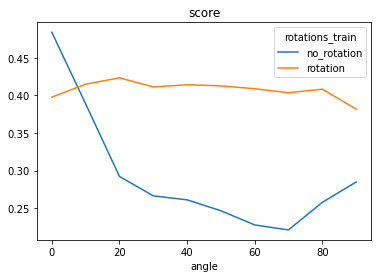

In [28]:
angle_pivot = log.pivot_table(values=['loss', 'score'], index='angle', columns='rotations_train')
angle_pivot['loss'].plot()
plt.title('loss')
plt.show()
angle_pivot['score'].plot()
plt.title('score')
plt.show()

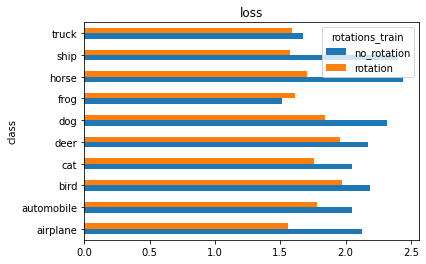

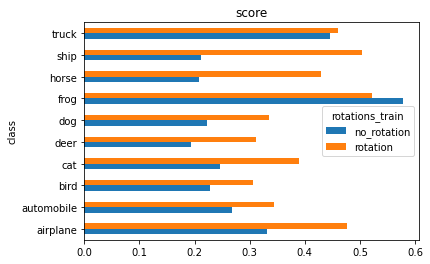

In [29]:
class_pivot = log.pivot_table(values=['loss', 'score'], index='class', columns='rotations_train')
class_pivot['loss'].plot(kind='barh')
plt.title('loss')
plt.show()
class_pivot['score'].plot(kind='barh')
plt.title('score')
plt.show()

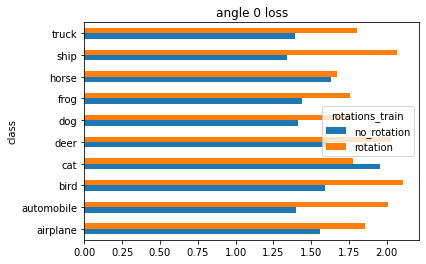

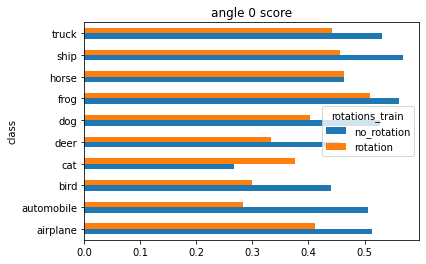

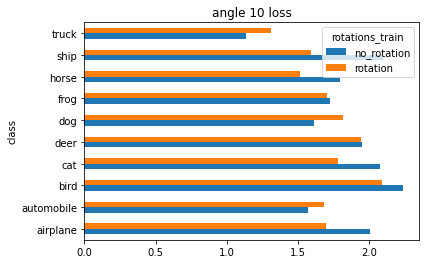

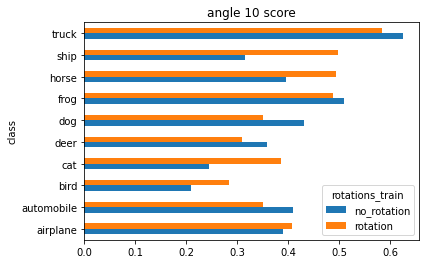

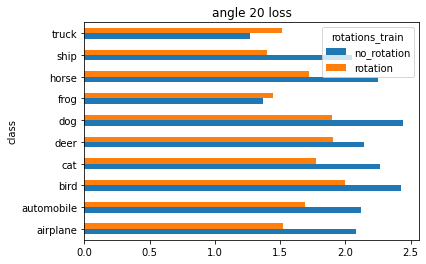

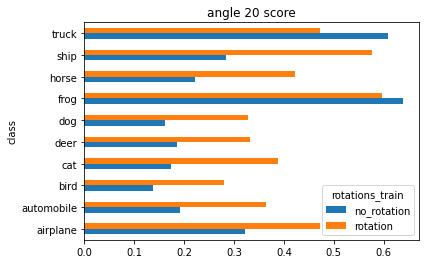

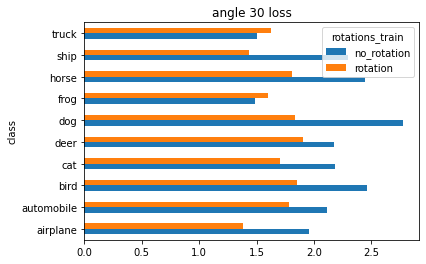

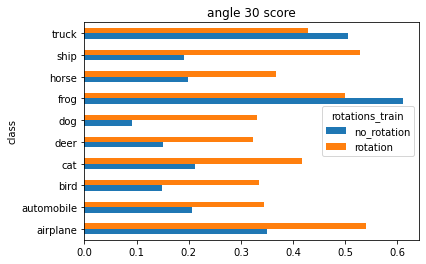

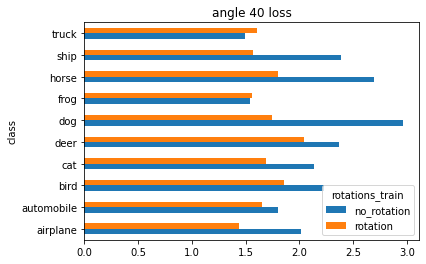

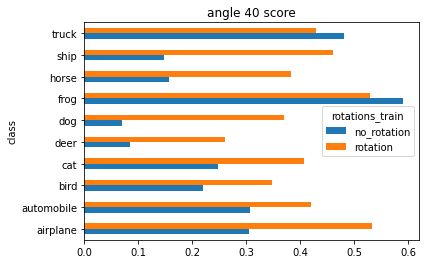

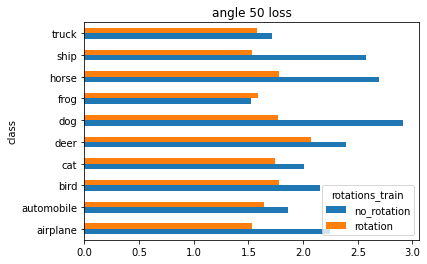

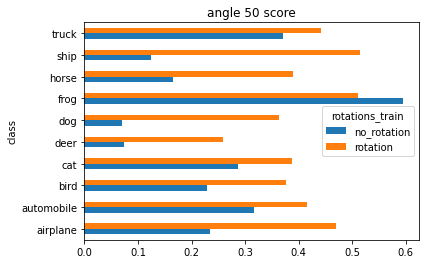

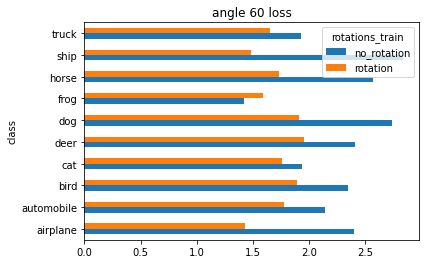

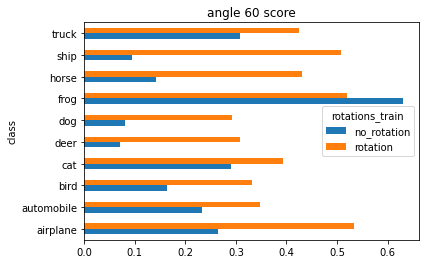

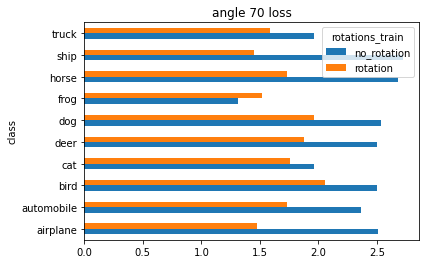

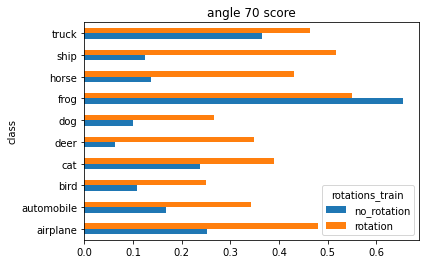

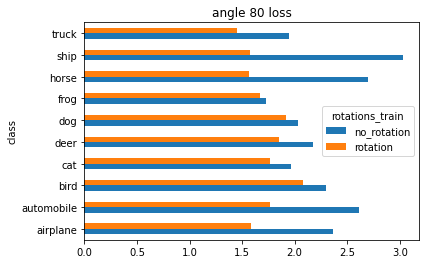

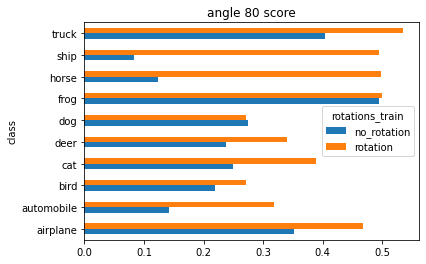

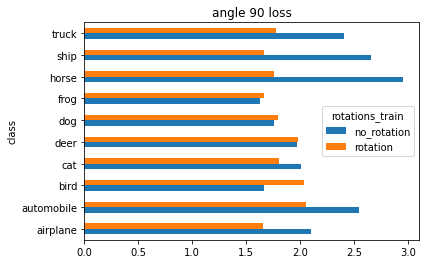

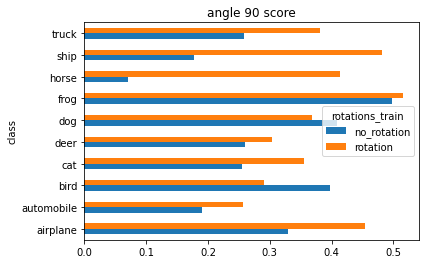

In [30]:
for angle in angles:
#     print(f'comparison on angle {angle} only')
#     display(pd.pivot_table(log[log['angle'] == angle], values=['loss', 'score'], index='class', columns='rotations_train'))
    angle_pivot = pd.pivot_table(log[log['angle'] == angle], values=['loss', 'score'], index='class', columns='rotations_train')
    angle_pivot['loss'].plot(kind='barh')
    plt.title(f'angle {angle} loss')
    plt.show()
    angle_pivot['score'].plot(kind='barh')
    plt.title(f'angle {angle} score')
    plt.show()